# Notebook 2: Feature Engineering & EDA
## HIGGS Boson Detection — Big Data ML Pipeline

This notebook covers:
- Exploratory Data Analysis (EDA)
- Missing value handling
- Feature engineering (domain-specific physics features)
- Scaling and normalisation
- Custom PySpark Transformer
- Train / Validation / Test split
- Persist processed data to Parquet


## 1. Setup

In [1]:
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler, MinMaxScaler,
    PCA, StringIndexer
)
from pyspark.ml.linalg import Vectors
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCols, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
import pyspark.ml.param as P
import yaml

with open('../config/spark_config.yaml') as f:
    spark_cfg = yaml.safe_load(f)

spark = (
    SparkSession.builder
    .appName('HIGGS-FeatureEngineering')
    .config('spark.driver.memory', spark_cfg['driver_memory'])
    .config('spark.executor.memory', spark_cfg['executor_memory'])
    .config('spark.sql.shuffle.partitions', spark_cfg['shuffle_partitions'])
    .config('spark.sql.adaptive.enabled', 'true')
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')
    .getOrCreate()
)
spark.sparkContext.setLogLevel('WARN')
print('SparkSession ready.')

SparkSession ready.


In [2]:

# Load processed 1% sample from notebook 1
CSV_PATH = '../data/higgs_1pct_processed.csv'
df = spark.read.csv(CSV_PATH, header=True, inferSchema=True)
print(f'Loaded: {df.count():,} rows, {len(df.columns)} cols')

FEATURE_NAMES = [
    'lepton_pT', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet1_pT', 'jet1_eta', 'jet1_phi', 'jet1_b_tag',
    'jet2_pT', 'jet2_eta', 'jet2_phi', 'jet2_b_tag',
    'jet3_pT', 'jet3_eta', 'jet3_phi', 'jet3_b_tag',
    'jet4_pT', 'jet4_eta', 'jet4_phi', 'jet4_b_tag',
    'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
]

LOW_LEVEL  = FEATURE_NAMES[:21]
HIGH_LEVEL = FEATURE_NAMES[21:]

Loaded: 81,704 rows, 30 cols


## 2. Exploratory Data Analysis

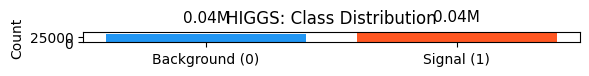

Class balance: [{'label': 0.0, 'count': 38395}, {'label': 1.0, 'count': 43309}]


In [3]:
# -------------------------------------------------------
# 2a. Class distribution
# -------------------------------------------------------
label_dist = df.groupBy('label').count().toPandas()
label_dist = label_dist.sort_values('label')

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Background (0)', 'Signal (1)'], label_dist['count'],
       color=['#2196F3', '#FF5722'])
ax.set_ylabel('Count')
ax.set_title('HIGGS: Class Distribution')
for i, v in enumerate(label_dist['count']):
    ax.text(i, v + 50000, f'{v/1e6:.2f}M', ha='center', fontsize=11)
plt.tight_layout()
plt.savefig('../data/samples/class_distribution.png', dpi=150)
plt.show()
print('Class balance:', label_dist.to_dict('records'))

In [4]:
# -------------------------------------------------------
# 2b. Feature statistics (Pandas sample for speed)
# -------------------------------------------------------
sample_pd = spark.read.csv('../data/samples/higgs_sample_50k.csv',
                           header=True, inferSchema=True).toPandas()

print('Sample shape:', sample_pd.shape)
sample_pd[FEATURE_NAMES].describe().round(4)

Sample shape: (81704, 30)


,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pT,jet1_eta,jet1_phi,jet1_b_tag,jet2_pT,...,jet4_eta,jet4_phi,jet4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,...,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000,81704.0000
mean,0.9917,0.0045,0.0043,1.0006,-0.0006,0.9920,-0.0001,-0.0025,0.9979,0.9924,...,-0.0047,-0.0013,0.9961,1.0338,1.0249,1.0510,1.0100,0.9693,1.0323,0.9594
std,0.5686,1.0080,1.0056,0.6032,1.0102,0.4732,1.0078,1.0048,1.0273,0.4974,...,1.0026,1.0083,1.3983,0.6830,0.3835,0.1668,0.3959,0.5121,0.3628,0.3133
min,0.2747,-2.4330,-1.7425,0.0023,-1.7439,0.1588,-2.9687,-1.7412,0.0000,0.1897,...,-2.4973,-1.7427,0.0000,0.1439,0.3429,0.2459,0.3304,0.0662,0.3850,0.4085
25%,0.5900,-0.7354,-0.8658,0.5769,-0.8789,0.6807,-0.6833,-0.8664,0.0000,0.6586,...,-0.7167,-0.8759,0.0000,0.7893,0.8460,0.9857,0.7675,0.6752,0.8194,0.7711
50%,0.8515,0.0058,0.0054,0.8940,0.0044,0.8967,-0.0010,-0.0071,1.0865,0.8901,...,-0.0021,-0.0008,0.0000,0.8946,0.9506,0.9897,0.9162,0.8736,0.9476,0.8727
75%,1.2372,0.7450,0.8749,1.2935,0.8765,1.1720,0.6872,0.8628,2.1731,1.2007,...,0.7033,0.8744,3.1020,1.0237,1.0829,1.0214,1.1432,1.1394,1.1413,1.0582
max,8.2828,2.4339,1.7432,9.6943,1.7433,5.0401,2.9677,1.7415,2.1731,6.7240,...,2.4980,1.7434,3.1020,21.0091,10.4621,5.9359,7.4832,9.1443,7.1224,5.3327


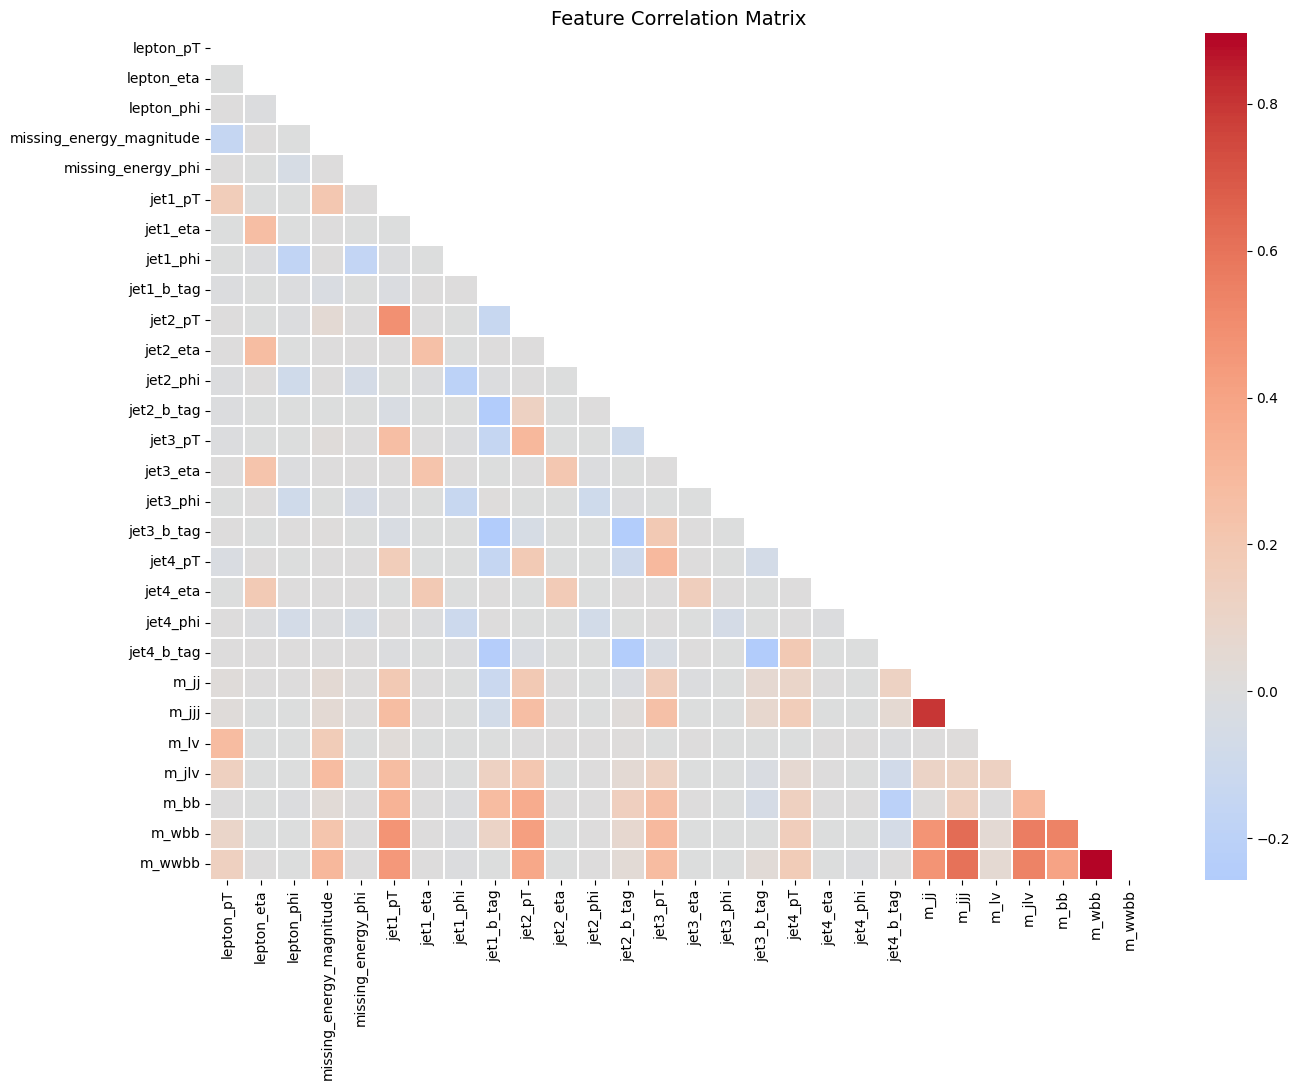

In [5]:
# -------------------------------------------------------
# 2c. Correlation heatmap
# -------------------------------------------------------
corr = sample_pd[FEATURE_NAMES].corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=0.3, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('../data/samples/correlation_heatmap.png', dpi=150)
plt.show()

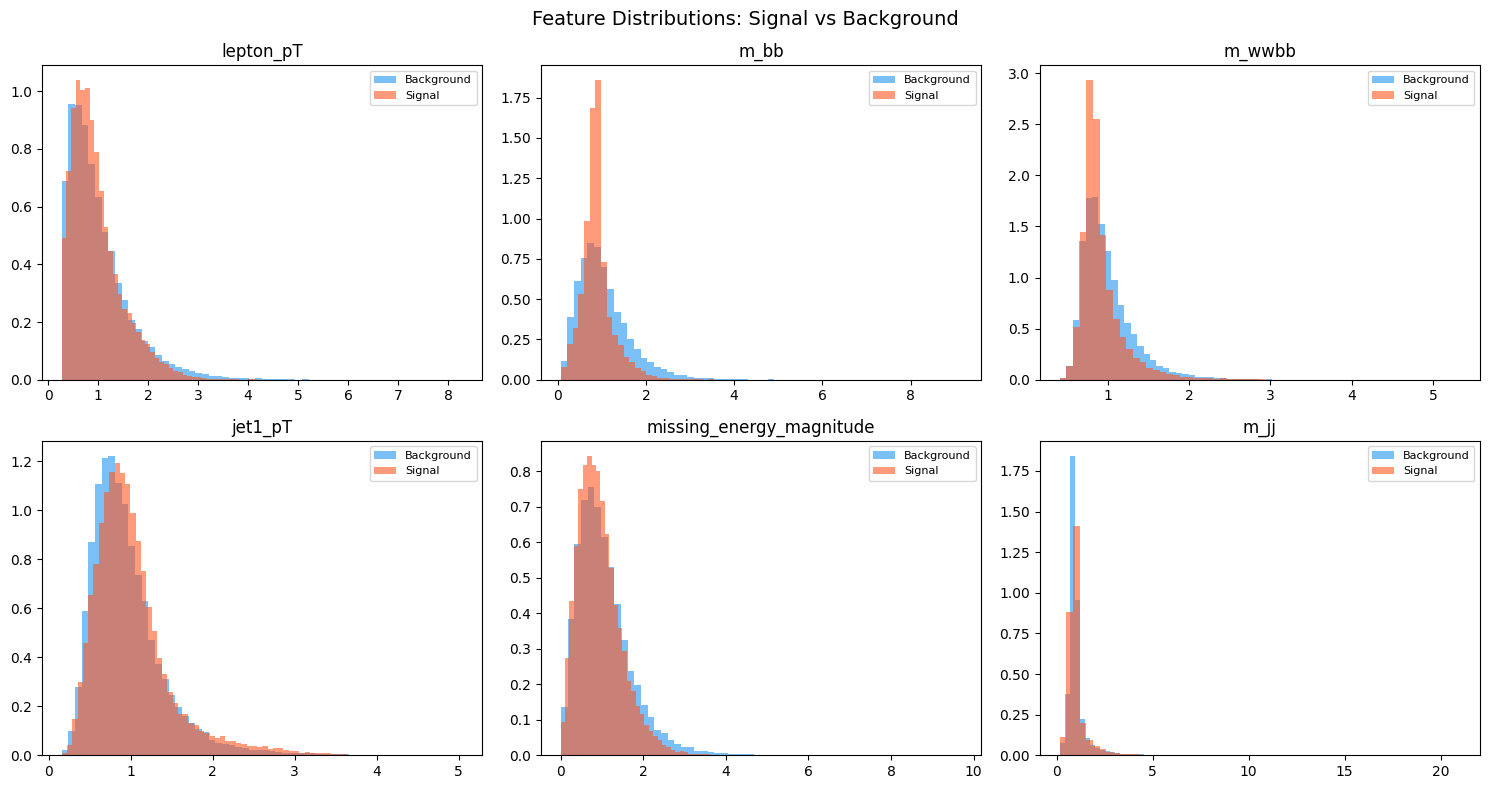

In [6]:
# -------------------------------------------------------
# 2d. Feature distributions: Signal vs Background
# -------------------------------------------------------
sig = sample_pd[sample_pd['label'] == 1]
bkg = sample_pd[sample_pd['label'] == 0]

plot_features = ['lepton_pT', 'm_bb', 'm_wwbb', 'jet1_pT',
                 'missing_energy_magnitude', 'm_jj']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feat in zip(axes.flatten(), plot_features):
    ax.hist(bkg[feat], bins=60, alpha=0.6, label='Background', color='#2196F3', density=True)
    ax.hist(sig[feat], bins=60, alpha=0.6, label='Signal',     color='#FF5722', density=True)
    ax.set_title(feat)
    ax.legend(fontsize=8)
fig.suptitle('Feature Distributions: Signal vs Background', fontsize=14)
plt.tight_layout()
plt.savefig('../data/samples/feature_distributions.png', dpi=150)
plt.show()

## 3. Missing Value Analysis & Handling

In [ ]:
# -------------------------------------------------------
# Check nulls & NaN on full Spark DataFrame
# HIGGS is known-clean, but we validate formally
# -------------------------------------------------------
null_expr = [
    F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c)
    for c in FEATURE_NAMES
]
null_df = df.select(null_expr).toPandas().T
null_df.columns = ['null_count']
null_df['null_pct'] = (null_df['null_count'] / df.count() * 100).round(4)
print(null_df[null_df['null_count'] > 0])
print(f'\nTotal columns with nulls: {(null_df["null_count"] > 0).sum()}')

Empty DataFrame
Columns: [null_count, null_pct]
Index: []

Total columns with nulls: 0


In [8]:
# -------------------------------------------------------
# Fill any nulls with column median (robust to outliers)
# Using approximate quantile for distributed computation
# -------------------------------------------------------
medians = {}
for col in FEATURE_NAMES:
    med = df.approxQuantile(col, [0.5], 0.001)[0]
    medians[col] = med

df_clean = df.fillna(medians)
print('Null filling complete.')
print(f'Sample medians: lepton_pT={medians["lepton_pT"]:.4f}, m_bb={medians["m_bb"]:.4f}')

Null filling complete.
Sample medians: lepton_pT=0.8504, m_bb=0.8734


## 4. Custom Transformer: PhysicsFeatureEngineer

In [9]:
# -------------------------------------------------------
# Custom PySpark Transformer
# Domain knowledge: particle physics interaction ratios
# These engineered features help separate signal from background
# -------------------------------------------------------
class PhysicsFeatureEngineer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    """
    Custom transformer that engineers domain-specific physics features:
    1. lepton_to_jet_pT_ratio   : lepton momentum / leading jet momentum
    2. total_visible_pT         : sum of all jet pT values
    3. bjet_multiplicity        : count of b-tagged jets
    4. mass_ratio_bb_wwbb       : m_bb / m_wwbb (Higgs decay signature)
    5. delta_eta_leading_jets   : |jet1_eta - jet2_eta| (VBF topology)
    """

    def _transform(self, df):
        df = df.withColumn(
            'lepton_to_jet_pT_ratio',
            F.col('lepton_pT') / (F.col('jet1_pT') + F.lit(1e-6))
        )
        df = df.withColumn(
            'total_visible_pT',
            F.col('jet1_pT') + F.col('jet2_pT') + F.col('jet3_pT') + F.col('jet4_pT')
        )
        df = df.withColumn(
            'bjet_multiplicity',
            (
                (F.col('jet1_b_tag') > 0.5).cast('int') +
                (F.col('jet2_b_tag') > 0.5).cast('int') +
                (F.col('jet3_b_tag') > 0.5).cast('int') +
                (F.col('jet4_b_tag') > 0.5).cast('int')
            )
        )
        df = df.withColumn(
            'mass_ratio_bb_wwbb',
            F.col('m_bb') / (F.col('m_wwbb') + F.lit(1e-6))
        )
        df = df.withColumn(
            'delta_eta_leading_jets',
            F.abs(F.col('jet1_eta') - F.col('jet2_eta'))
        )
        return df

physics_transformer = PhysicsFeatureEngineer()
df_engineered = physics_transformer.transform(df_clean)

ENGINEERED_FEATURES = [
    'lepton_to_jet_pT_ratio', 'total_visible_pT',
    'bjet_multiplicity', 'mass_ratio_bb_wwbb', 'delta_eta_leading_jets'
]

ALL_FEATURES = FEATURE_NAMES + ENGINEERED_FEATURES
print(f'Total features after engineering: {len(ALL_FEATURES)}')
df_engineered.select(ENGINEERED_FEATURES).show(5)

Total features after engineering: 33
+----------------------+------------------+-----------------+------------------+----------------------+
|lepton_to_jet_pT_ratio|  total_visible_pT|bjet_multiplicity|mass_ratio_bb_wwbb|delta_eta_leading_jets|
+----------------------+------------------+-----------------+------------------+----------------------+
|    2.8712048395877834|3.8684248000000006|                2|0.7981012685037263|            0.54576613|
|     1.411047369112088|3.8478918999999996|                1|0.9371260733423358|   0.19939775999999998|
|    1.2248310903495565|        2.57554771|                2|0.5674706640658419|            0.45719592|
|      1.93871104503297|2.6769839199999996|                2|1.1961335027606588|             0.9236635|
|    0.9573812328017883|        4.27706683|                2|0.9743247185453494|            0.07828304|
+----------------------+------------------+-----------------+------------------+----------------------+
only showing top 5 rows


## 5. Feature Scaling Pipeline

In [10]:
# -------------------------------------------------------
# MLlib Pipeline:
#   Step 1: VectorAssembler — combine features into DenseVector
#   Step 2: StandardScaler — zero mean, unit variance
#           Justification: SVM & LR sensitive to feature scale;
#           tree methods (RF, GBT) are scale-invariant but
#           scaling doesn't hurt and keeps consistent pipeline
# -------------------------------------------------------
assembler = VectorAssembler(
    inputCols=ALL_FEATURES,
    outputCol='raw_features',
    handleInvalid='skip'
)

scaler = StandardScaler(
    inputCol='raw_features',
    outputCol='features',
    withMean=True,
    withStd=True
)

# Rename label to standard MLlib column
df_labelled = df_engineered.withColumnRenamed('label', 'raw_label') \
                            .withColumn('label', F.col('raw_label').cast(DoubleType()))

prep_pipeline = Pipeline(stages=[assembler, scaler])

print('Fitting preprocessing pipeline...')
t0 = time.time()
prep_model = prep_pipeline.fit(df_labelled)
df_prepared = prep_model.transform(df_labelled)
print(f'Pipeline fit + transform: {time.time()-t0:.2f}s')

df_prepared.select('label', 'features').show(3, truncate=True)

Fitting preprocessing pipeline...
Pipeline fit + transform: 3.28s
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[1.91019452172645...|
|  1.0|[-0.2036911614919...|
|  0.0|[-0.0273195043925...|
+-----+--------------------+
only showing top 3 rows


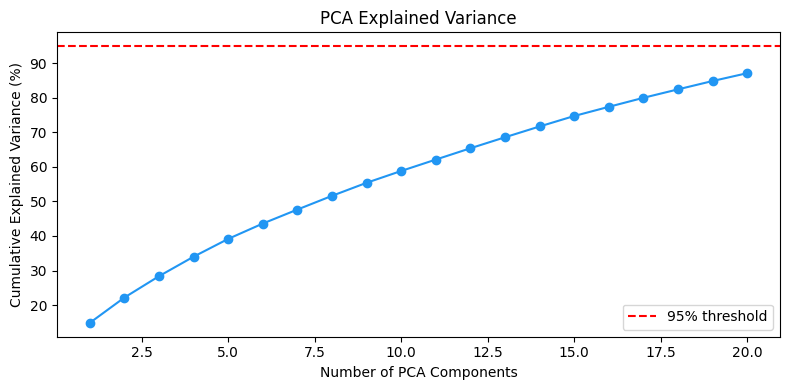

Variance explained by 20 PCs: 87.17%


In [11]:
# -------------------------------------------------------
# PCA — optional dimensionality reduction
# Reduce 33 → 20 components, retaining ~95% variance
# Useful for visualisation and faster SVM training
# -------------------------------------------------------
pca = PCA(k=20, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(df_prepared)

explained_var = pca_model.explainedVariance.toArray()
cum_var = np.cumsum(explained_var)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, 21), cum_var * 100, 'o-', color='#2196F3')
ax.axhline(95, color='red', linestyle='--', label='95% threshold')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.set_title('PCA Explained Variance')
ax.legend()
plt.tight_layout()
plt.savefig('../data/samples/pca_variance.png', dpi=150)
plt.show()

print(f'Variance explained by 20 PCs: {cum_var[19]*100:.2f}%')

## 6. Train / Validation / Test Split

In [12]:
# -------------------------------------------------------
# Fast train/val/test split (70/15/15)
# Using simple random split for speed on 1% sample
# -------------------------------------------------------
df_final = df_prepared.select('label', 'features')

# Simple random split
train_df, val_test_df = df_final.randomSplit([0.7, 0.3], seed=42)
val_df, test_df = val_test_df.randomSplit([0.5, 0.5], seed=42)

n_train = train_df.count()
n_val   = val_df.count()
n_test  = test_df.count()
total   = n_train + n_val + n_test

print(f'Train : {n_train:>9,}  ({n_train/total*100:.1f}%)')
print(f'Val   : {n_val:>9,}  ({n_val/total*100:.1f}%)')
print(f'Test  : {n_test:>9,}  ({n_test/total*100:.1f}%)')

Train :    57,452  (70.3%)
Val   :    12,294  (15.0%)
Test  :    11,958  (14.6%)


In [13]:
# -------------------------------------------------------
# Save splits to CSV for use in notebook 3
# Convert feature vectors to strings for CSV compatibility
# -------------------------------------------------------
print('Converting to Pandas and saving splits as CSV...')

# Convert Spark DataFrames to Pandas for CSV saving
train_pd = train_df.select('label', 'features').toPandas()
val_pd = val_df.select('label', 'features').toPandas()
test_pd = test_df.select('label', 'features').toPandas()

# Serialize feature vectors to comma-separated strings
def serialize_features(pdf):
    pdf = pdf.copy()
    pdf['features'] = pdf['features'].apply(lambda x: ','.join([f"{v:.6f}" for v in x]))
    return pdf

train_pd = serialize_features(train_pd)
val_pd = serialize_features(val_pd)
test_pd = serialize_features(test_pd)

train_pd.to_csv('../data/train.csv', index=False)
val_pd.to_csv('../data/val.csv', index=False)
test_pd.to_csv('../data/test.csv', index=False)

print(f'Train saved: {len(train_pd):,} rows')
print(f'Val saved  : {len(val_pd):,} rows')
print(f'Test saved : {len(test_pd):,} rows')

spark.stop()
print(' Feature engineering complete!')

Converting to Pandas and saving splits as CSV...
Train saved: 57,452 rows
Val saved  : 12,294 rows
Test saved : 11,958 rows
 Feature engineering complete!
